# Regression Plots

This Jupyter Notebook is part of the time travel distance project. In this notebook we visualise the results of the linear regression models.

## Import

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# read data
fit_combi_abs = sm.load("models/fit_combi_abs.pickle")
fit_combi = sm.load("models/fit_combi.pickle")
fit_horiz = sm.load("models/fit_horiz.pickle")
df = pd.read_csv('data/combined_data.csv')

## Only horizontal model

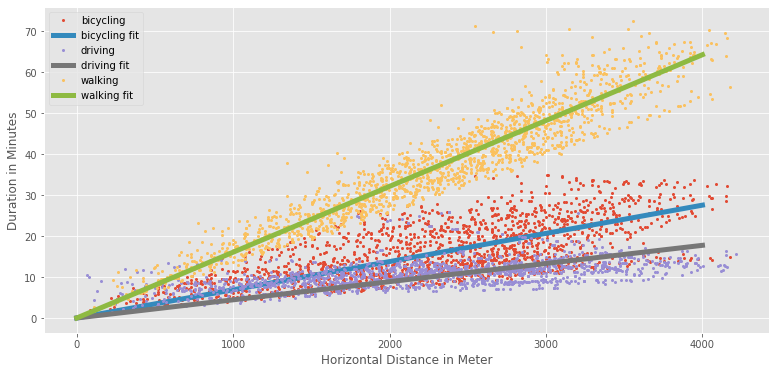

In [10]:
plt.style.use('ggplot')
plt.figure(figsize=(13, 6))

groups = df.groupby('mode')
for name, group in groups:
    plt.plot(group.distance_horizontal, group.duration/60, marker='o', linestyle='', ms=2, label=name)
    
    # grid
    x = np.linspace(0, 4000)
    if name == 'driving':
      y_hat = x * fit_horiz.params['distance_horizontal']

    elif name == 'bicycling':
      y_hat = x * fit_horiz.params['distance_horizontal'] + x * fit_horiz.params['distance_horizontal:isBicycling[T.True]']   

    else:
      y_hat = x * fit_horiz.params['distance_horizontal'] + x * fit_horiz.params['distance_horizontal:isBicycling[T.True]'] + x * fit_horiz.params['distance_horizontal:isWalking[T.True]']

    plt.plot(x, y_hat/60, lw=5, label=name+' fit')

plt.xlabel('Horizontal Distance in Meter')
plt.ylabel('Duration in Minutes')
plt.legend();

## Simple combined model

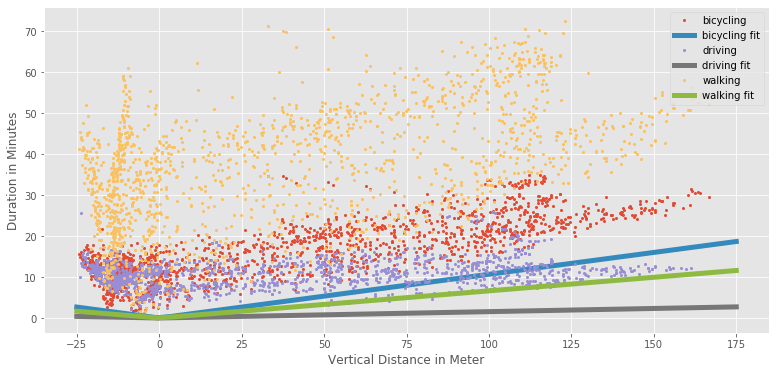

In [16]:
plt.style.use('ggplot')
plt.figure(figsize=(13, 6))

groups = df.groupby('mode')
for name, group in groups:
    plt.plot(group.distance_vertical, group.duration/60, marker='o', linestyle='', ms=2, label=name)
    
    # grid
    x = np.linspace(-25, 175)
    if name == 'driving':
      y_hat = np.abs(x * fit_combi_abs.params['distance_vertical_abs'])

    elif name == 'bicycling':
      y_hat = np.abs(x * fit_combi_abs.params['distance_vertical_abs'] + x * fit_combi_abs.params['distance_vertical_abs:isBicycling[T.True]'])

    else:
      y_hat = np.abs(x * fit_combi_abs.params['distance_vertical_abs'] + x * fit_combi_abs.params['distance_vertical_abs:isBicycling[T.True]'] + x * fit_combi_abs.params['distance_vertical_abs:isWalking[T.True]'])

    plt.plot(x, y_hat/60, lw=5, label=name+' fit')

plt.xlabel('Vertical Distance in Meter')
plt.ylabel('Duration in Minutes')
plt.legend();

In [19]:
# define grid of points
x = np.arange(-25, 175, 5)
y = np.arange(0, 4000, 5)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()

# calculate regression planes
z_driving = np.abs(xv* fit_combi_abs.params['distance_vertical_abs']) + yv * fit_combi_abs.params['distance_horizontal']
z_bicycle = z_driving + np.abs(xv * fit_combi_abs.params['distance_vertical_abs:isBicycling[T.True]']) + yv * fit_combi_abs.params['distance_horizontal:isBicycling[T.True]']    
z_walking = z_bicycle + np.abs(xv* fit_combi_abs.params['distance_vertical_abs:isWalking[T.True]']) + yv * fit_combi_abs.params['distance_horizontal:isWalking[T.True]']    

# reshape
z_bicycle = z_bicycle.reshape((y.shape[0], x.shape[0]))
z_driving = z_driving.reshape((y.shape[0], x.shape[0]))
z_walking = z_walking.reshape((y.shape[0], x.shape[0]))

In [ ]:
# plot
fig = px.scatter_3d(df, x='distance_vertical', y='distance_horizontal', z='duration',
              color='mode', width=1000, height=800)

# style
fig.update_traces(marker_size = 2)
yellow = [[0, '#FFDB58'], [1, '#FFDB58']]
blue = [[0, '#034efc'], [1, '#034efc']]
red = [[0, '#fc0330'], [1, '#fc0330']]

# add regression planes
fig.add_trace(go.Surface(x=x, y=y, z=z_driving, showscale=False, colorscale=yellow))
fig.add_trace(go.Surface(x=x, y=y, z=z_bicycle, showscale=False, colorscale=blue))
fig.add_trace(go.Surface(x=x, y=y, z=z_walking, showscale=False, colorscale=red))

fig.show()

# Extended combined model

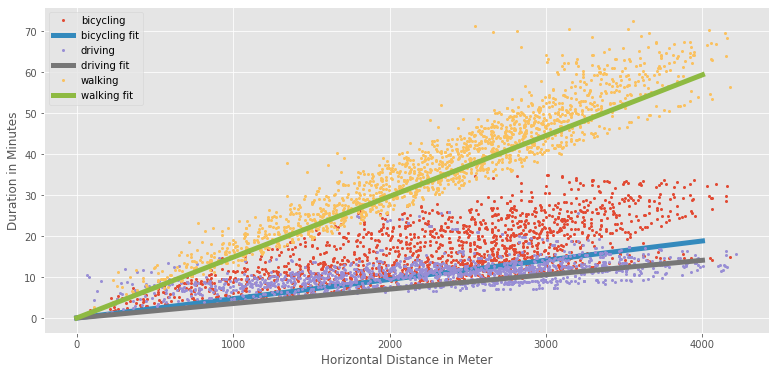

In [24]:
plt.style.use('ggplot')
plt.figure(figsize=(13, 6))

groups = df.groupby('mode')
for name, group in groups:
    plt.plot(group.distance_horizontal, group.duration/60, marker='o', linestyle='', ms=2, label=name)
    
    # grid
    x = np.linspace(0, 4000)
    if name == 'driving':
      y_hat = x * fit_combi.params['distance_horizontal']

    elif name == 'bicycling':
      y_hat = x * fit_combi.params['distance_horizontal'] + x * fit_combi.params['distance_horizontal:isBicycling[T.True]']   

    else:
      y_hat = x * fit_combi.params['distance_horizontal'] + x * fit_combi.params['distance_horizontal:isBicycling[T.True]'] + x * fit_combi.params['distance_horizontal:isWalking[T.True]']

    plt.plot(x, y_hat/60, lw=5, label=name+' fit')

plt.xlabel('Horizontal Distance in Meter')
plt.ylabel('Duration in Minutes')
plt.legend();

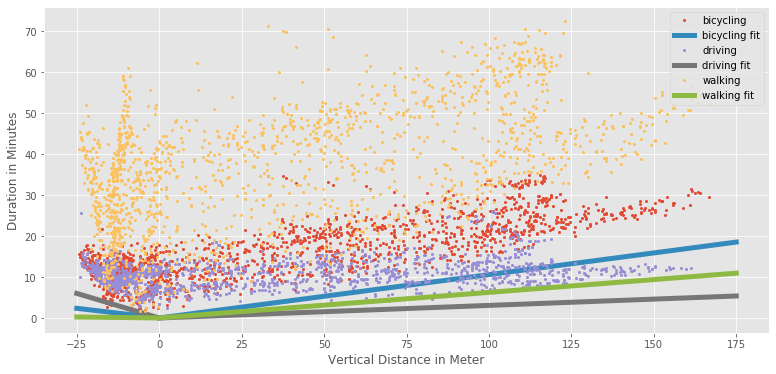

In [18]:
plt.style.use('ggplot')
plt.figure(figsize=(13, 6))

groups = df.groupby('mode')
for name, group in groups:
    plt.plot(group.distance_vertical, group.duration/60, marker='o', linestyle='', ms=2, label=name)    
    
    # grid
    x_pos = np.linspace(0, 175)
    x_neg = np.abs(np.linspace(-25, 0))
    
    if name == 'driving':
        y_neg = x_neg * fit_combi.params['distance_vertical_neg']
        y_pos = x_pos * fit_combi.params['distance_vertical_pos']
        y_hat = np.concatenate((y_neg, y_pos))
       

    elif name == 'bicycling':
        y_neg = x_neg * fit_combi.params['distance_vertical_neg'] + x_neg * fit_combi.params['distance_vertical_neg:isBicycling[T.True]']   
        y_pos = x_pos * fit_combi.params['distance_vertical_pos'] + x_pos * fit_combi.params['distance_vertical_pos:isBicycling[T.True]']   
        y_hat = np.concatenate((y_neg, y_pos))
    
    else:
        y_neg = x_neg * fit_combi.params['distance_vertical_neg'] + x_neg * fit_combi.params['distance_vertical_neg:isBicycling[T.True]'] + x_neg * fit_combi.params['distance_vertical_neg:isWalking[T.True]']
        y_pos = x_pos * fit_combi.params['distance_vertical_pos'] + x_pos * fit_combi.params['distance_vertical_pos:isBicycling[T.True]'] + x_pos * fit_combi.params['distance_vertical_pos:isWalking[T.True]']
        y_hat = np.concatenate((y_neg, y_pos))
        
    x = np.concatenate((-1*x_neg, x_pos))
    plt.plot(x, y_hat/60, lw=5, label=name+' fit')

plt.xlabel('Vertical Distance in Meter')
plt.ylabel('Duration in Minutes')
plt.legend();

### 3D Plot

In [36]:
# define grid of points
x_neg = np.abs(np.linspace(-25, 0))
x_pos = np.linspace(0, 175)
x = np.concatenate((-x_neg, x_pos))
y = np.arange(0, 4000)

# negative meshgrid
xv_neg, yv_neg = np.meshgrid(x_neg, y)
xv_neg = xv_neg.flatten()
yv_neg = yv_neg.flatten()

#positive mehsgrid
xv_pos, yv_pos = np.meshgrid(x_pos, y)
xv_pos = xv_pos.flatten()
yv_pos = yv_pos.flatten()

# calculate negative regression planes
z_driving_neg = xv_neg * fit_combi.params['distance_vertical_neg'] + yv_neg * fit_combi.params['distance_horizontal']
z_bicycle_neg = z_driving_neg + xv_neg * fit_combi.params['distance_vertical_neg:isBicycling[T.True]'] + yv_neg * fit_combi.params['distance_horizontal:isBicycling[T.True]']    
z_walking_neg = z_bicycle_neg + xv_neg * fit_combi.params['distance_vertical_neg:isWalking[T.True]'] + yv_neg * fit_combi.params['distance_horizontal:isWalking[T.True]']    

# calculate positive regression planes
z_driving_pos = xv_pos * fit_combi.params['distance_vertical_pos'] + yv_pos * fit_combi.params['distance_horizontal']
z_bicycle_pos = z_driving_pos + xv_pos * fit_combi.params['distance_vertical_pos:isBicycling[T.True]'] + yv_pos * fit_combi.params['distance_horizontal:isBicycling[T.True]']    
z_walking_pos = z_bicycle_pos + xv_pos * fit_combi.params['distance_vertical_pos:isWalking[T.True]'] + yv_pos * fit_combi.params['distance_horizontal:isWalking[T.True]']    


# reshape
z_bicycle_neg = z_bicycle_neg.reshape((y.shape[0], x_neg.shape[0]))
z_driving_neg = z_driving_neg.reshape((y.shape[0], x_neg.shape[0]))
z_walking_neg = z_walking_neg.reshape((y.shape[0], x_neg.shape[0]))

z_bicycle_pos = z_bicycle_pos.reshape((y.shape[0], x_pos.shape[0]))
z_driving_pos = z_driving_pos.reshape((y.shape[0], x_pos.shape[0]))
z_walking_pos = z_walking_pos.reshape((y.shape[0], x_pos.shape[0]))


print(z_bicycle_neg.shape)
print(z_bicycle_pos.shape)


(4000, 50)
(4000, 50)


In [ ]:
# plot
fig = px.scatter_3d(df, x='distance_vertical', y='distance_horizontal', z='duration',
              color='mode', width=1000, height=800)

# style
fig.update_traces(marker_size = 2)
yellow = [[0, '#FFDB58'], [1, '#FFDB58']]
blue = [[0, '#034efc'], [1, '#034efc']]
red = [[0, '#fc0330'], [1, '#fc0330']]

# add regression planes
fig.add_trace(go.Surface(x=x_pos, y=y, z=z_driving_pos, showscale=False, colorscale=yellow))
fig.add_trace(go.Surface(x=x_pos, y=y, z=z_bicycle_pos, showscale=False, colorscale=blue))
fig.add_trace(go.Surface(x=x_pos, y=y, z=z_walking_pos, showscale=False, colorscale=red))

fig.add_trace(go.Surface(x=-x_neg, y=y, z=z_driving_neg, showscale=False, colorscale=yellow))
fig.add_trace(go.Surface(x=-x_neg, y=y, z=z_bicycle_neg, showscale=False, colorscale=blue))
fig.add_trace(go.Surface(x=-x_neg, y=y, z=z_walking_neg, showscale=False, colorscale=red))

fig.show()

## BIC comparison

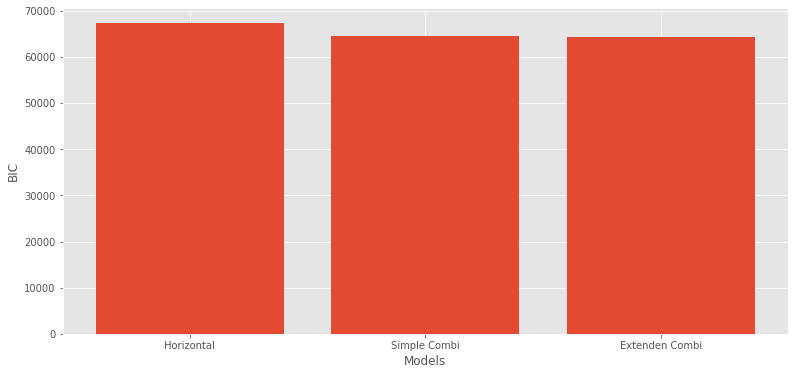

In [39]:
plt.style.use('ggplot')
plt.figure(figsize=(13, 6))

plt.bar(['Horizontal', 'Simple Combi', 'Extenden Combi'], [fit_horiz.bic, fit_combi_abs.bic,  fit_combi.bic])
plt.xlabel('Models')
plt.ylabel('BIC');